Projet Algèbre Linéaire pour la Data Science
================================================

Ce notebook à pour but d'expliquer la méthode de [SVD randomisée](https://research.fb.com/blog/2014/09/fast-randomized-svd/). <br>

Sommaire :
--------------------
1. Calcul d'une SVD classique et mesure de temps
2. Explication et implémentation de la version randomisée
3. Mesures pour la version randomisée en changeant les paramètres
   1. Calcul de performance
   2. Estimation de l'erreur
4. Calculs de statistiques sur l'erreur moyenne
   
   

# 1. Librairies python et récupération de l'image

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import normalize
from time import perf_counter
from utils import *
from profiler import *
from svd_func import *

np.set_printoptions(threshold=5)


# img = getColouredImage('./resources/verysmall_600x355.jpg') #SVD : instant
# img = getColouredImage('./resources/small_1280x720.jpg')    #SVD : about 1 sec
# img = getColouredImage('./resources/medium_5184x2060.jpg')  #SVD : about 7 sec
img = getColouredImage('./resources/medium_2448x3264.jpeg') #SVD : about 10 sec
# img = getColouredImage('./resources/medium_6946x3906.jpg')  #SVD : about 1 minute 
# img = getColouredImage('./resources/big_12kx8k.jpg')        #SVD : about 5 minutes
# img = getColouredImage('./resources/huge_12kx14k.jpg')      #SVD : about 15 minutes

# img = getColouredImage('./resources/big_12kx8k.jpg')
# img = getColouredImage('./resources/huge_12kx14k.jpg')

img = toGrayScale(img)
print("Shape : ",np.array(img).shape)
print("Total size :",np.array(img).shape[0]*np.array(img).shape[1])

Shape :  (3264, 2448)
Total size : 7990272


# 2. SVD classique

In [2]:
A = np.array(img).transpose() #we transpose because the pic is horizontal
m, n = A.shape
size = m*n

print("Matrix shape :", A.shape)
print("Total number of elements :", size)

start = perf_counter()  
A_reconstructed = svd_regular(A)
end = perf_counter()

exact_error, rms_magnitude = compute_error(A, A_reconstructed)
print_result(exact_error, rms_magnitude, end-start, "Regular SVD")
SVD_TIMER = end-start

Matrix shape : (2448, 3264)
Total number of elements : 7990272

####################################################################
Regular SVD
>>> Duration : 7.27758 sec.
>>> Rooted mean squared Error (RMSE) : 10e-15
>>> Rooted sum squared Erros (RSSE)  : 1.0100678255230686e-09
####################################################################


On constate que cette méthode est efficace car l'erreur $\lVert A - \tilde{A} \rVert$ est très faible (d'ordre `10e-16`). Cependant, elle est très couteuse.
# 3. Méthodes de SVD randomisées
Dans cette partie nous allons projeter notre matrice $A$ dans un sous espace vectoriel plus petit afin de réaliser une SVD efficace sur ce sous espace restreint. <br>

## Algèbre linéaire randomisée
Nous allons dans un premier temps nous intéresser aux méthodes d'algèbre linéaire randomisées. <br>
Notamment la manière dont nous allons choisir notre "petit" sous espace dans lequel nous allons projeter $A$.
<br>
L'idée principale est donc de générer un sous-espace de $A$ qui approxime l'espace complet de $A$. <br>
Pour cela, nous allons choisir une matrice $\Omega$, générée de manière *aléatoire* et allons projeter A dans cet espace. <br>
La question naturelle qui se pose est : ***comment choisir efficacement notre $\Omega$ ?***

### Matrice à valeurs Gausiennes, Uniformes, ou "colonnes"
Nous allons observer le comportement de $\Omega$ en fonction de la méthode utilisée pour sa génération aléatoire.
Ensuite, nous étudierons ces différents $\Omega$ notamment à l'aide de SVD. <br>

Prenons 3 matrices : <br>
$$
\Omega_{1} \in \mathbb{R}^{m \times n} : \Omega_{i,j} \sim \mathcal{N}(0,1) \\ 
\ \\
\Omega_{2} \in \mathbb{R}^{m \times n} : \Omega_{i,j} \sim \mathcal{U}([0,1]) \\
\ \\
\Omega_{3} \in \mathbb{R}^{m \times n} : \forall i \in \llbracket0~;~n\rrbracket,~ \exists!~j \sim \mathcal{U}(\llbracket0,m\rrbracket) : \Omega_{i,j} = 1 \\
et\ \Omega_{i,k}=0 \ \ \forall~k \ne j
$$
- La première est une matrice à valeurs Gausiennes.<br>
- La seconde est une matrice à valeurs Uniformes.<br>
- La troisième est une matrice avec une unique valeur à 1 pour chaque colonne.<br>


Nous pouvons jouer sur la valeur de $m$ et observer comment convergent les valeurs singulières de ces matrices générées aléatoirement.

Sigma O1 (gaussian):
 [[1.02 0.   0.   ... 0.   0.   0.  ]
 [0.   1.02 0.   ... 0.   0.   0.  ]
 [0.   0.   1.01 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.98 0.   0.  ]
 [0.   0.   0.   ... 0.   0.98 0.  ]
 [0.   0.   0.   ... 0.   0.   0.98]]


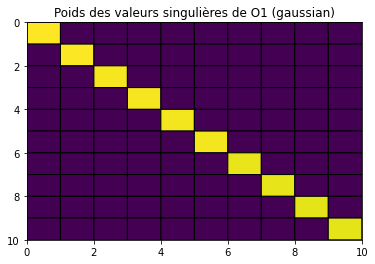

Sigma O2 (uniform):
 [[2.78 0.   0.   ... 0.   0.   0.  ]
 [0.   0.51 0.   ... 0.   0.   0.  ]
 [0.   0.   0.51 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.5  0.   0.  ]
 [0.   0.   0.   ... 0.   0.49 0.  ]
 [0.   0.   0.   ... 0.   0.   0.49]]


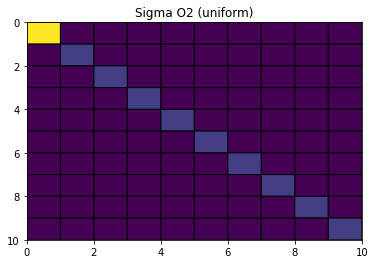

Sigma O3 (columns):
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


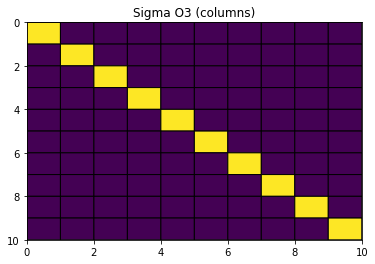

In [3]:
m = 10000
n = 10

Omega1=np.random.normal(0, 1, (m, n))

Omega2=np.random.uniform(0, 1, (m, n))

Omega3=np.zeros((m, n))
for c in Omega3.T :
    random_int = randint(0, m)
    c[random_int] = 1
    
U1, S1, Vt1 = np.linalg.svd(normalize(Omega1.T), full_matrices=False)
U2, S2, Vt2 = np.linalg.svd(normalize(Omega2.T), full_matrices=False)
U3, S3, Vt3 = np.linalg.svd(normalize(Omega3), full_matrices=False)

print("Sigma O1 (gaussian):\n", np.diag(S1).round(2))
plt.figure(0)
plt.title("Poids des valeurs singulières de O1 (gaussian)")
plt.gca().invert_yaxis()
plt.pcolor(np.diag(S1), edgecolors='k', linewidths=1)
plt.show()

print("Sigma O2 (uniform):\n", np.diag(S2).round(2))
plt.figure(1)
plt.title("Sigma O2 (uniform)")
plt.gca().invert_yaxis()
plt.pcolor(np.diag(S2), edgecolors='k', linewidths=1)
plt.show()

print("Sigma O3 (columns):\n", np.diag(S3).round(2))
plt.figure(3)
plt.title("Sigma O3 (columns)")
plt.gca().invert_yaxis()
plt.pcolor(np.diag(S3), edgecolors='k', linewidths=1)
plt.show()

Ces matrices $\Omega_{i}$ sont utilisées pour projeter A et obtenir un sous espace réduit sur lequel nous pourrons réaliser des factorisations dans la suite du notebook (en commençant par une décomposition QR). <br>

## Application d'une SVD sur le sous espace aléatoire
Nous allons maintenant nous intéresser à la convergence de l'erreur $\lVert A - \tilde{A} \rVert$ en fonction des différents $\Omega_i$. <br>
Pour cette simulation, nous prenons $k = 50$, $k$ étant le nombre de colonnes que l'on garde pour la génération des matrices aléatoires dans le cas des SVD randomisées. Dans le cas de la SVD classique, 50 correspond au nombre de vecteurs et valeurs singuliers que nous gardons pour la reconstruction de $A$. <br>
Nous allons afficher ces valeurs pour les des matrices carrées dans $\mathbb{R}^{n \times n}$ avec $n$ prenant les différentes tailles du tableau `sizes`.

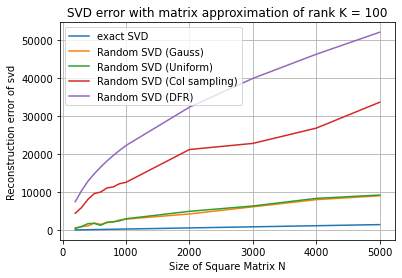

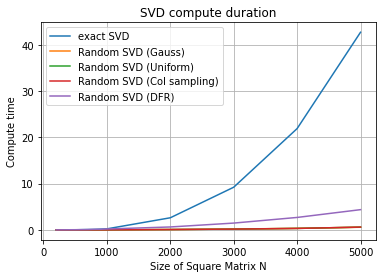

In [4]:
##########
# WARNING : this cell takes about 10 minutes to compute, you might just want to look at the graphs
##########

sizes = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]
fixed_rank_errors_random_matrixes(sizes, k=100)

![fixed_rank_errors](graphs/error_and_duration_size_increasing.png)

## Application de la SVD sur photos de différentes tailles

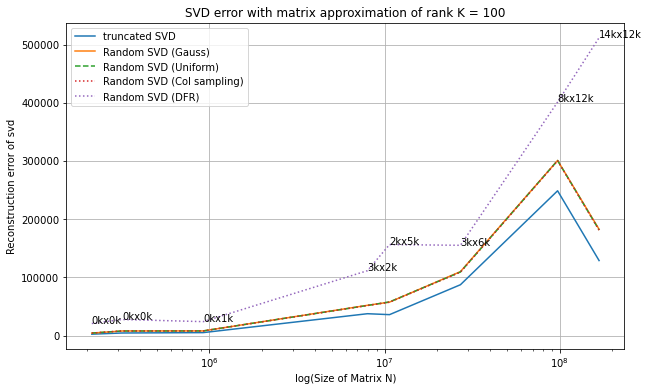

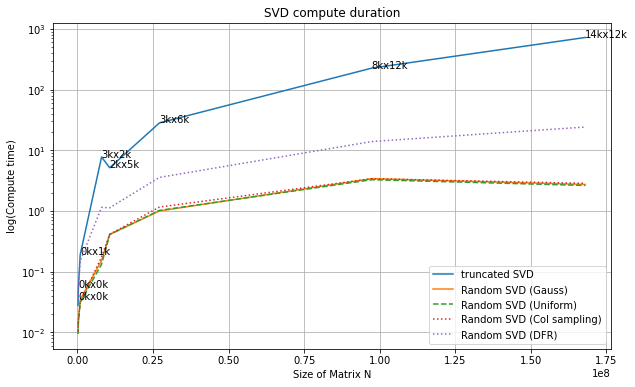

In [5]:
Image.MAX_IMAGE_PIXELS = None # Shut the warning

paths = ["./resources/" + x for x in os.listdir("./resources") if x.split(".")[-1] in ["jpg", "jpeg"]]

fixed_rank_errors_photos(paths, k=100)

Nous allons continuer la suite du notebook en utilisant la RSVD basée sur une **matrice à valeurs gausiennes**.
On va exécuter $t$ fois la méthode sur la photo de départ en augmentant $t$ fois la valeur de $k$ jusqu'à atteindre `k_max`.

In [6]:
##########
# WARNING : long cell
##########
k_max = 500
t = 10

execute_t_times(20, r_svd, A, k_max, verbose=0)

TypeError: execute_t_times() missing 1 required positional argument: 'kernel'

## Et au final... à l'oeil nu ?
Après tous ces tests et ces méthodes, voyons ce que cela donne à l'oeil nu sur l'image de départ. Bien sûr, cela n'est pas représentatif de toutes les applications, pour du calcul scientifique par exemple, on peut réduire l'erreur générée par la RSVD au prix de la performance. Il faut donc juger en fonction du besoin quel type de matrice randomisée nous choisissons (*bien que la gaussienne semble être efficace dans la plupart des cas*), ainsi que la taille de notre troncature k.   

Total size is :  7990272
	m =  2448
	n =  3264
Truncature size k is : 327, which is 10.018% of columns n


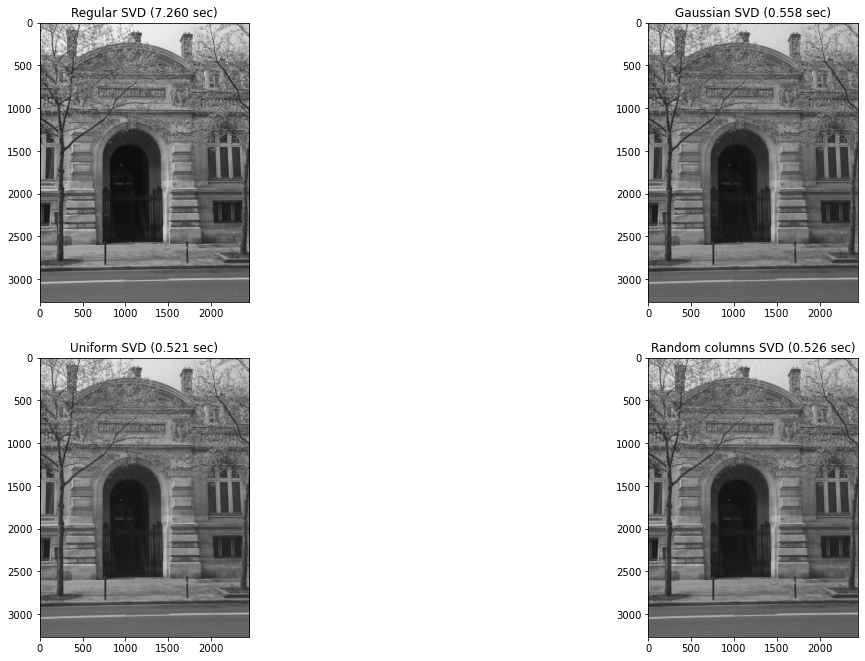

In [ ]:
m, n = A.shape
# k = 50
k = int(n*0.10) + 1

print("Total size is : ",m*n)
print("\tm = ", m)
print("\tn = ", n)

percentage = k/n*100
print("\rTruncature size k is : {}, which is {:.3f}% of columns n".format(k, percentage))


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20/1.77))
s = perf_counter()
A_tilde = svd_regular(A, k)
e = perf_counter()
axes[0][0].set_title("Regular SVD ({:.3f} sec)".format(e-s))
axes[0][0].imshow(A_tilde.T, cmap='gray')

s = perf_counter()
A_tilde = svd_rand_gaussian(A, k)
e = perf_counter()
axes[0][1].set_title("Gaussian SVD ({:.3f} sec)".format(e-s))
axes[0][1].imshow(A_tilde.T, cmap='gray')

s = perf_counter()
A_tilde = svd_rand_uniform(A, k)
e = perf_counter()
axes[1][0].set_title("Uniform SVD ({:.3f} sec)".format(e-s))
axes[1][0].imshow(A_tilde.T, cmap='gray')

s = perf_counter()
A_tilde = svd_rand_columns(A, k)
e = perf_counter()
axes[1][1].set_title("Random columns SVD ({:.3f} sec)".format(e-s))
axes[1][1].imshow(A_tilde.T, cmap='gray')

plt.show()

On voit donc bien que, à l'oeil nu, si k est assez "grand", la différence sera à peine visible, et le gain de temps est considérable ! <br>

# 4. Etude statistique
Dans cette partie nous allons nous intéresser à l'erreur et le temps d'exécution moyens de la SVD randomisée en utilisant une matrice à valeurs Gausiennes. <br>
Voici comment nous allons procéder :
1. $N$ réalisations de la méthode RSVD, on garde les erreurs exactes (RSSE) et les durées d'exécution
2. Affichage des données récupérées sous forme d'histogramme
3. Ajustement à une loi de densité connue grâce à `fit` 
4. Estimation de l'espérance de l'erreur et du temps moyens     


*EDIT : Au final, nous allons seulement étudier l'espérance de la RSSE, et non pas le temps de calcul. Nous sommes sur python donc nous ne savons pas réellement comment est géré le cache, surtout avec jupyter, les valeurs ne sont donc pas représentatives sur N exécutions **à la suite***.

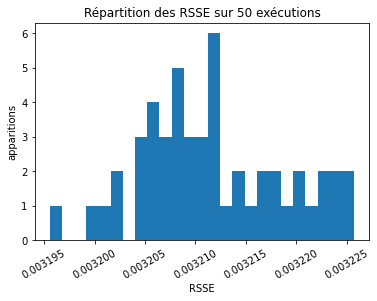

In [ ]:
#N = 500
N = 50
#N = 25
errors = []

for n in range(N):
    # if n%10 == 0 : print("Loop ",n)
    A_tilde = svd_rand_gaussian(A, k=k)

    
    error, magnitude = compute_error(A, A_tilde)
    errors.append(error)
    
nb_elem = A.size
errors = np.asarray(errors) / nb_elem

plt.figure("Errors")
plt.hist(pd.array(errors), bins=int(N/2))
plt.title("Répartition des RSSE sur {} exécutions".format(N))
plt.ylabel("apparitions")
plt.xlabel("RSSE")
plt.xticks(rotation=30)
plt.show()

Nous allons essayer de fit sur la loi normale car la courbe ressemble à une gausienne (lorsque N tend vers l'infini). <br>
Cela permet d'approximer l'esperance et l'écart type de l'erreur pour une matrice de la même taille que $A$. 

Nb elements A :  7990272
k =  327
Erreur moyenne pour chaque élément A[i,j] : 
  >> Esperance : 0.003211663007842125
  >> Ecart type : 7.037508592899098e-06


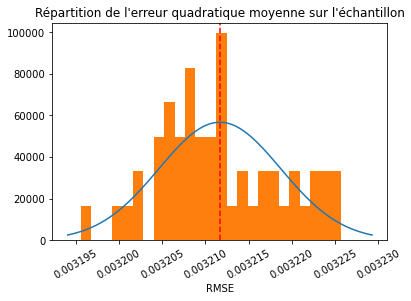

In [ ]:
#Calcul dse paramètres qui maximisent la vraissemblance pour une loi normale avec nos données
m, std = ss.norm.fit(errors)

m = m
std = std

x = np.linspace(m - 2.5*std, m + 2.5*std, 100)
fig, ax = plt.subplots()
ax.plot(x, ss.norm.pdf(x, m, std))
ax.axvline(m, ls='--', color='red') #expected value
ax.hist(pd.array(errors), bins=int(N/2), density=True)
plt.title("Répartition de l'erreur quadratique moyenne sur l'échantillon")
plt.xlabel("RMSE")
plt.xticks(rotation=30)

print("Nb elements A : ", A.size)
print("k = ", k)
print("Erreur moyenne pour chaque élément A[i,j] : ")
#On divise par nb_elem pour avoir l'erreur et l'ecart type aux composantes
print("  >> Esperance : {}\n  >> Ecart type : {}".format(m, std))

Nous avons répeté cette opération pour plusieurs tailles de matrices en gardant toujours **k = 10% de n**, pour simuler l'exigence d'un certain niveau de qualité d'approximation qu'on serait sûr d'atteindre avec 10% de n. <br>
Ensuite, nous avons exporté les résultats dans le fichier data.csv, dans le but d'essayer de dégager une corrélation entre la taille de la matrice et l'erreur quadratique moyenne. <br>

Nous avons simulé dans ces conditions :

- Tailles des matrices générés :
  ```python
  ns = [i for i in range(5, 5000, 500)]
  ms = [i for i in range(10, 10000, 1000)]
  ```
  - m = 10, 1010, ..., 9010 
  - n = 5, 505, 1005, ..., 4505
- Nombre d'itérations pour l'estimateur :
  - **250**


Pour chaque nouvelle matrice de taille $m\times n$ nous avons calculé 250 fois la rsvd gausienne et avons trouvé une espérance empirique des RSSE.
Voici les résultats que nous obtenons en utilisants ces valeurs :

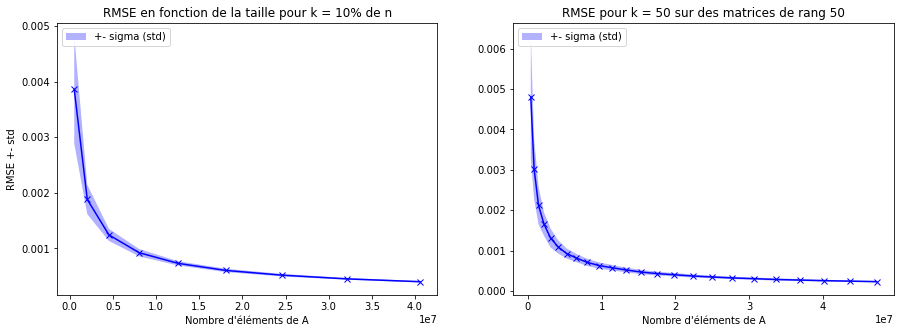

Matrice de covariance :
[[ 2.1714896e+14 -9.9078000e+03]
 [-9.9078000e+03  0.0000000e+00]]


In [ ]:
#read data.csv
data_csv = pd.read_csv(r'./resources/data_k_dynamic.csv', header=None, skiprows=[0])
tab = np.array(data_csv)

#on récupère les colonnes qui nous intéressent
sizes = tab.T[0][1:]
means = tab.T[3][1:]
stds = tab.T[4][1:]

#on moyenne sur la taille pour connaitre l'erreur moyenne par composantes
means = means/sizes
stds = stds/sizes

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_ylabel("RMSE +- std")
axes[0].set_xlabel("Nombre d'éléments de A")
axes[0].set_title("RMSE en fonction de la taille pour k = 10% de n")
axes[0].plot(sizes, means, 'bx-')
axes[0].fill_between(sizes, means - stds, means + stds, facecolor='blue', alpha=0.3,
                label='+- sigma (std)')
axes[0].legend(loc='upper left')
# axes[0].imshow(A_tilde.T, cmap='gray')



#La même chose avec un k fixe et un peu plus d'itérations
data_csv = pd.read_csv(r'./resources/data_k_static.csv', header=None, skiprows=[0])
tab = np.array(data_csv)
sizes = tab.T[0][1:]
means = tab.T[3][1:]
stds = tab.T[4][1:]
means = means/sizes
stds = stds/sizes

axes[1].set_xlabel("Nombre d'éléments de A")
axes[1].set_title("RMSE pour k = 50 sur des matrices de rang 50")
axes[1].plot(sizes, means, 'bx-')
axes[1].fill_between(sizes, means - stds, means + stds, facecolor='blue', alpha=0.3,
                label='+- sigma (std)')
axes[1].legend(loc='upper left')

plt.show()


c = np.cov([sizes, means])
print("Matrice de covariance :")
print(c.round(2))


Il est intéressant de noter que ces valeurs moyennes d'erreur ont tendance à diminuer lorsque **la taille de la matrice augmente** et qu'on défini k en pourcentage. On ressent bien que c'est une méthode utile pour les matrices de grandes tailles, comme celles utilisées chez les GAFAM (Facebook, Google,...). <br>
On peut donc conclure que le côté aléatoire/randomisé de ces méthodes est lissé par la loi des grands nombres. <br>
<br>
La prochaine étape est de réaliser ces mêmes méthodes en utilisant des matrices creuses, car l'objectif de ces méthodes est la performance, et le stockage mémoire en fait partie.